In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')
import os
os.chdir("gdrive/My Drive/Colab Notebooks/cs412hw5")

Mounted at /content/gdrive


In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import Dataset
from torch import optim
import numpy as np
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
from collections import Counter
from tqdm.notebook import tqdm
import time
from dataloader import DataLoader
from LR import Logistic
from MLP import MLP
from CNN import CNN


if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load Data

In [2]:
if __name__ == '__main__':
    dataloader = DataLoader(Xtrainpath='data/train-images-idx3-ubyte.gz',
                            Ytrainpath='data/train-labels-idx1-ubyte.gz',
                            Xtestpath='data/t10k-images-idx3-ubyte.gz',
                            Ytestpath='data/t10k-labels-idx1-ubyte.gz')
    Xtrain, Ytrain, Xtest, Ytest = dataloader.load_data()

# Logistic Regression

In [4]:
def plot_acc(acc, epochs):
    indices = [i for i in range(1, epochs+1)]
    plt.plot(indices, acc)
    plt.title("Accuracy Plot")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.show()

def plot_ll(ll, epochs):
    indices = [i for i in range(1, epochs+1)]
    plt.plot(indices, ll)
    plt.title("log Likelihood Plot")
    plt.ylabel("log Likelihood")
    plt.xlabel("Epoch")
    plt.show()

def train_LR(Logistic, epochs, Xtrn, Ytrn, Xtst, Ytst):
    tst_acc = []
    log_likelihood = []
    Logistic.w = np.random.normal(0, .05, size=(np.shape(Xtrn)[1], 1))

    for _ in range(epochs):
        h = logistic.sigmoid(Xtrn)
        logistic.update(Xtrn, h, Ytrn) #update weights

        ll = logistic.likelihood(Xtrn, Ytrn) # likelihood
        log_likelihood.append(ll)

        pred = np.array([1 if h >= 0.5 else 0 for h in logistic.sigmoid(Xtst)]) # prediction
        acc = (pred == Ytst).sum() / len(Ytst)
        tst_acc.append(acc)

    plot_acc(tst_acc, epochs) #plot accuracy
    plot_ll(log_likelihood, epochs) # plot likelihood

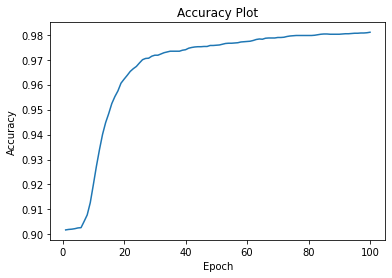

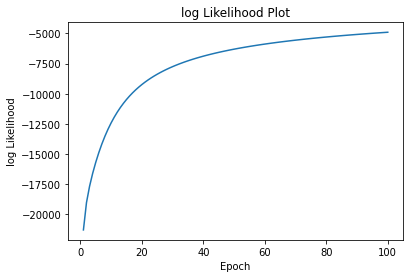

In [5]:
if __name__ == '__main__':
    # preprocess data
    Xtrn = np.copy(Xtrain)
    Xtst = np.copy(Xtest)
    Xtrn = np.reshape(Xtrn, (np.shape(Xtrn)[0], -1)) # flatten
    Xtst = np.reshape(Xtst, (np.shape(Xtst)[0], -1))
    Xtrn = np.true_divide(Xtrn, 255) # normalize
    Xtst = np.true_divide(Xtst, 255)
    Ytrn = np.array([1 if y == 0 else 0 for y in Ytrain]) # convert into binary
    Ytst = np.array([1 if y == 0 else 0 for y in Ytest])
    Ytrn = Ytrn.reshape(np.shape(Ytrn)[0], 1)

    LR = 0.1 / len(Xtrain)
    Epochs = 100
    logistic = Logistic(LR)

    train_LR(logistic, Epochs, Xtrn, Ytrn, Xtst, Ytst)

Both of the curves increase rapidly at first and then converge. The accuracy mostly grows from $5^{th}$ to $30^{th}$ iteration. The curve of log likelihood is always smaller than 0 and it is very smooth.

# K-Nearest Neighbor

In [9]:
def plot_acc(k, l2_acc, l1_acc):
    plt.plot(k, l2_acc, label="Euclidean")
    plt.plot(k, l1_acc, label="Manhattan")
    plt.title("Accuracy Plot")
    plt.ylabel("Accuracy")
    plt.xlabel("Num of k")
    plt.legend()
    plt.show()

def train_kNN(arr_k, Xtrn, Ytrn, Xtst, Ytst):
    l2_acc, l1_acc = [], []
    pred_l2 = np.zeros((len(Ytst), len(arr_k)))
    pred_l1 = np.zeros((len(Ytst), len(arr_k)))
    tree = KDTree(list(Xtrn)) # use kdtree to store xtrain

    for i, x in enumerate(Xtst):
        idx_l2 = tree.query(x, k=arr_k[-1], p=2)[1] # idx of max k neighbors
        idx_l1 = tree.query(x, k=arr_k[-1], p=1)[1]

        for j, k in enumerate(arr_k):
            idx_l2_temp, idx_l1_temp = idx_l2[:k], idx_l1[:k] # idx of k neighbors
            pred_l2[i,j] = Counter([Ytrn[q] for q in idx_l2_temp]).most_common(1)[0][0]
            pred_l1[i,j] = Counter([Ytrn[q] for q in idx_l1_temp]).most_common(1)[0][0]

    for j in range(len(arr_k)):
        l2_acc.append((pred_l2[:,j] == Ytst).mean()) # calculate accuracy 
        l1_acc.append((pred_l1[:,j] == Ytst).mean())
    plot_acc(arr_k, l2_acc, l1_acc) # plot accuracy

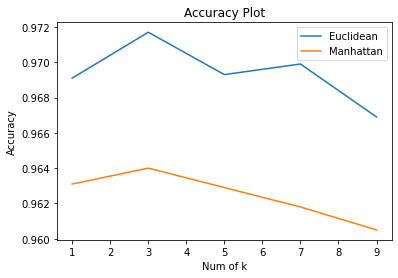

In [10]:
if __name__ == '__main__':
    # preprocess data
    Xtrn = np.copy(Xtrain)
    Xtst = np.copy(Xtest)
    Xtrn = np.reshape(Xtrn, (np.shape(Xtrn)[0], -1)) # flatten
    Xtst = np.reshape(Xtst, (np.shape(Xtst)[0], -1))
    Xtrn = np.true_divide(Xtrn, 255) # normalize
    Xtst = np.true_divide(Xtst, 255)

    train_kNN([1,3,5,7,9], Xtrn, Ytrain, Xtst, Ytest)

Both Euclidean and Manhattan distance get the highest accuracy when k = 3 and lowest when k = 9.

# Helper Functions and Class

In [8]:
class MyDataSet(Dataset):
    def __init__(self, X, y):
        self.data = torch.FloatTensor(X)
        self.label = torch.LongTensor(y)
    
    def __getitem__(self, index):
        x = self.data[index]
        y = self.label[index]
        return x, y
  
    def __len__(self):
        return len(self.data)

In [9]:
def accuracy(output, labels):
    preds = output.argmax(dim=1)
    correct = (preds == labels).sum().float() # count correct num of pred
    acc = correct / len(labels)
    return acc

def plot_loss(trn, tst, trn_std, tst_std, epochs):
    indices = [i for i in range(1, epochs+1)]
    plt.errorbar(indices, trn, yerr=trn_std, label="train")
    plt.errorbar(indices, tst, yerr=tst_std, label="test")
    plt.title("Loss Plot")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()
    
def plot_acc(trn, tst, trn_std, tst_std, epochs):
    indices = [i for i in range(1, epochs+1)]
    plt.errorbar(indices, trn, yerr=trn_std, label="train")
    plt.errorbar(indices, tst, yerr=tst_std, label="test")
    plt.title("Accuracy Plot")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

def train(model, epochs, n_iter, trn_data, tst_data, optimizer, criterion, device):
    trn_loss_dict, tst_loss_dict = np.zeros((n_iter, epochs)), np.zeros((n_iter, epochs))
    trn_acc_dict, tst_acc_dict = np.zeros((n_iter, epochs)), np.zeros((n_iter, epochs))
    
    for i in range(n_iter):
        trn_loss_list, tst_loss_list = np.array([]), np.array([])
        trn_acc_list, tst_acc_list = np.array([]), np.array([])

        for _ in range(epochs):
            start = time.time()
            trn_loss, tst_loss = 0, 0
            trn_acc, tst_acc = 0, 0

            # training(w/ gradient descent)
            model.train()
            for data, label in trn_data:
                data, label = data.to(device), label.to(device)

                optimizer.zero_grad()
                output = model(data)
                acc = accuracy(output, label)
                loss = criterion(output, label)
                loss.backward()
                optimizer.step()

                trn_loss += loss.item()
                trn_acc += acc.item()
            trn_loss_list = np.append(trn_loss_list, trn_loss / len(trn_data))
            trn_acc_list = np.append(trn_acc_list, trn_acc / len(trn_data))
            
            # testing(w/ no gradient descent)
            model.eval()
            for data, label in tst_data:
                data, label = data.to(device), label.to(device)

                with torch.no_grad():
                    output = model(data)
                    acc = accuracy(output, label)
                    loss = criterion(output, label)
                    tst_acc += acc.item()
                    tst_loss += loss.item()
            tst_loss_list = np.append(tst_loss_list, tst_loss / len(tst_data))
            tst_acc_list = np.append(tst_acc_list, tst_acc / len(tst_data))
        
        trn_loss_dict[i] = np.add(trn_loss_dict[i], trn_loss_list)
        trn_acc_dict[i] = np.add(trn_acc_dict[i], trn_acc_list)
        tst_loss_dict[i] = np.add(tst_loss_dict[i], tst_loss_list)
        tst_acc_dict[i] = np.add(tst_acc_dict[i], tst_acc_list)

    plot_loss(np.mean(trn_loss_dict, axis=0), np.mean(tst_loss_dict, axis=0), np.std(trn_loss_dict, axis=0), np.std(tst_loss_dict, axis=0), epochs) #plot loss
    plot_acc(np.mean(trn_acc_dict, axis=0), np.mean(tst_acc_dict, axis=0), np.std(trn_acc_dict, axis=0), np.std(tst_acc_dict, axis=0), epochs) # plot acc

# Multi-Layer Perceptron

In [13]:
if __name__ == '__main__':
    LR = 0.001
    BATCH_SIZE = 256
    N_EPOCHS = 40
    N_ITER = 5
    NUM_CLASSES = 10
    INPUT_DIM = 784
    HIDDEN_DIM = 128

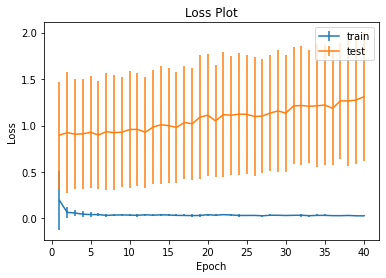

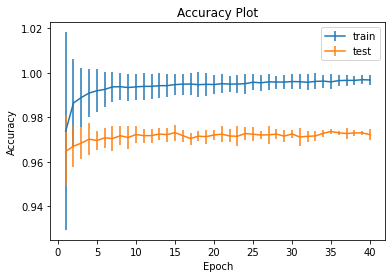

In [14]:
if __name__ == '__main__':
    # load data
    trn = MyDataSet(Xtrain, Ytrain)
    tst = MyDataSet(Xtest, Ytest)
    trn = data.DataLoader(trn, batch_size=BATCH_SIZE, drop_last=True, shuffle=True)
    tst = data.DataLoader(tst, batch_size=1000, drop_last=True, shuffle=False)
    
    # load model
    mlp = MLP(INPUT_DIM, HIDDEN_DIM, NUM_CLASSES).to(device)
    optimizer = torch.optim.Adam(mlp.parameters(), lr=LR, weight_decay=5e-6)
    criterion = nn.CrossEntropyLoss().to(device)
    
    train(mlp, N_EPOCHS, N_ITER, trn, tst, optimizer, criterion, device)

Learning rate is 0.001

Batch size is 256

Hidden size is 128

Optimizer is Adam


# Convolutional neural network

In [11]:
if __name__ == '__main__':
    LR = 0.001
    BATCH_SIZE = 256
    N_EPOCHS = 40
    N_ITER = 5
    NUM_CLASSES = 10
    IN_CHANNEL = 1
    OUT_CHANNEL = 16
    DROPOUT = 0.5

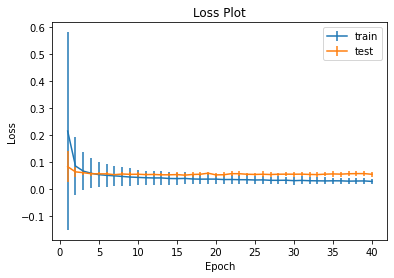

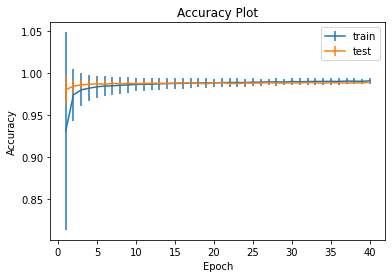

In [12]:
if __name__ == '__main__':
    # load data
    trn = MyDataSet(Xtrain, Ytrain)
    tst = MyDataSet(Xtest, Ytest)
    trn = data.DataLoader(trn, batch_size=BATCH_SIZE, drop_last=True, shuffle=True)
    tst = data.DataLoader(tst, batch_size=1000, drop_last=True, shuffle=False)
    
    # load model
    cnn = CNN(IN_CHANNEL, OUT_CHANNEL, NUM_CLASSES, DROPOUT).to(device)
    optimizer = torch.optim.Adam(cnn.parameters(), lr=LR, weight_decay=5e-6)
    criterion = nn.CrossEntropyLoss().to(device)
    
    train(cnn, N_EPOCHS, N_ITER, trn, tst, optimizer, criterion, device)

Learning rate is 0.001

Batch size is 256

Dropout rate is 0.5

Optimizer is Adam

| Layers | 4-Layer CNN |
| :- | :- |
| Conv1 | kernel = 16x4x4, stride = 2, reflection pad = 1 |
|       | BatchNorm + Leaky ReLU |
| Conv2 | kernel = 32x4x4, stride = 2, reflection pad = 1 |
|       | BatchNorm + Adaptive Max Pooling(2x2) |
| FC1   | hidden size = 64 |
|       | ReLU + Dropout(0.5) |
| FC2   | output size = 10